In [42]:
from scipy import io as spio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [43]:
emnist = spio.loadmat("data/matlab/emnist-digits.mat")

## Emnist
see https://arxiv.org/pdf/1702.05373v1.pdf for breakdown of dataset

In [44]:
# Load balanced letters dataset from csv
df_train = pd.read_csv("data/emnist-letters-train.csv")

# Data Shape
data shape of df_train is:

column 0 is the class

columns 1 to 785 are the image data

In [45]:
# get labels from first column
df_train_y = df_train.iloc[:,[0]]
# get 1d image data from other 784 columns
df_train_x = df_train.iloc[:, 1:785]

In [46]:
df_train_y.head()

,23
0,7
1,16
2,15
3,23
4,17


# Class transform
By default the Y classes are made up of 26 numbers each representing a letter of the alphabet,
as we only care about the characters 'm' and 'f', we will use a piecewise function to set anything that is not 'm' or 'f' to 0,
any class that is 'f' to 1, and any class that is 'm' to 2.

| class | mapping |
|-------|---------|
|   0   | unknown |
|   1   |    f    |
|   2   |    m    |

In [53]:
y = np.asarray(df_train_y)
train_y = np.piecewise(y, [(y != 6) & (y != 13), y == 6, y == 13], [0, 1, 2])

In [59]:
train_y.max()

2

In [49]:
df_train_x.head()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.406,0.407,0.408,0.409,0.410,0.411,0.412,0.413,0.414,0.415
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Letter Data Transform
The training examples are 1d (1x784) and need to be resized to 28x28

In [50]:
train_x = df_train_x.values.reshape((88799, 28, 28))

Then the images need to be rotated 90 degrees, the 0th axis of our train_x is the image index itself, thus we only want to rotate axis 1 and 2 as they are the actual image data

The rot90 function is able to rotate an entire numpy matrix

In [51]:
train_x = np.fliplr(train_x)
train_x = np.rot90(train_x, axes=(2, 1))

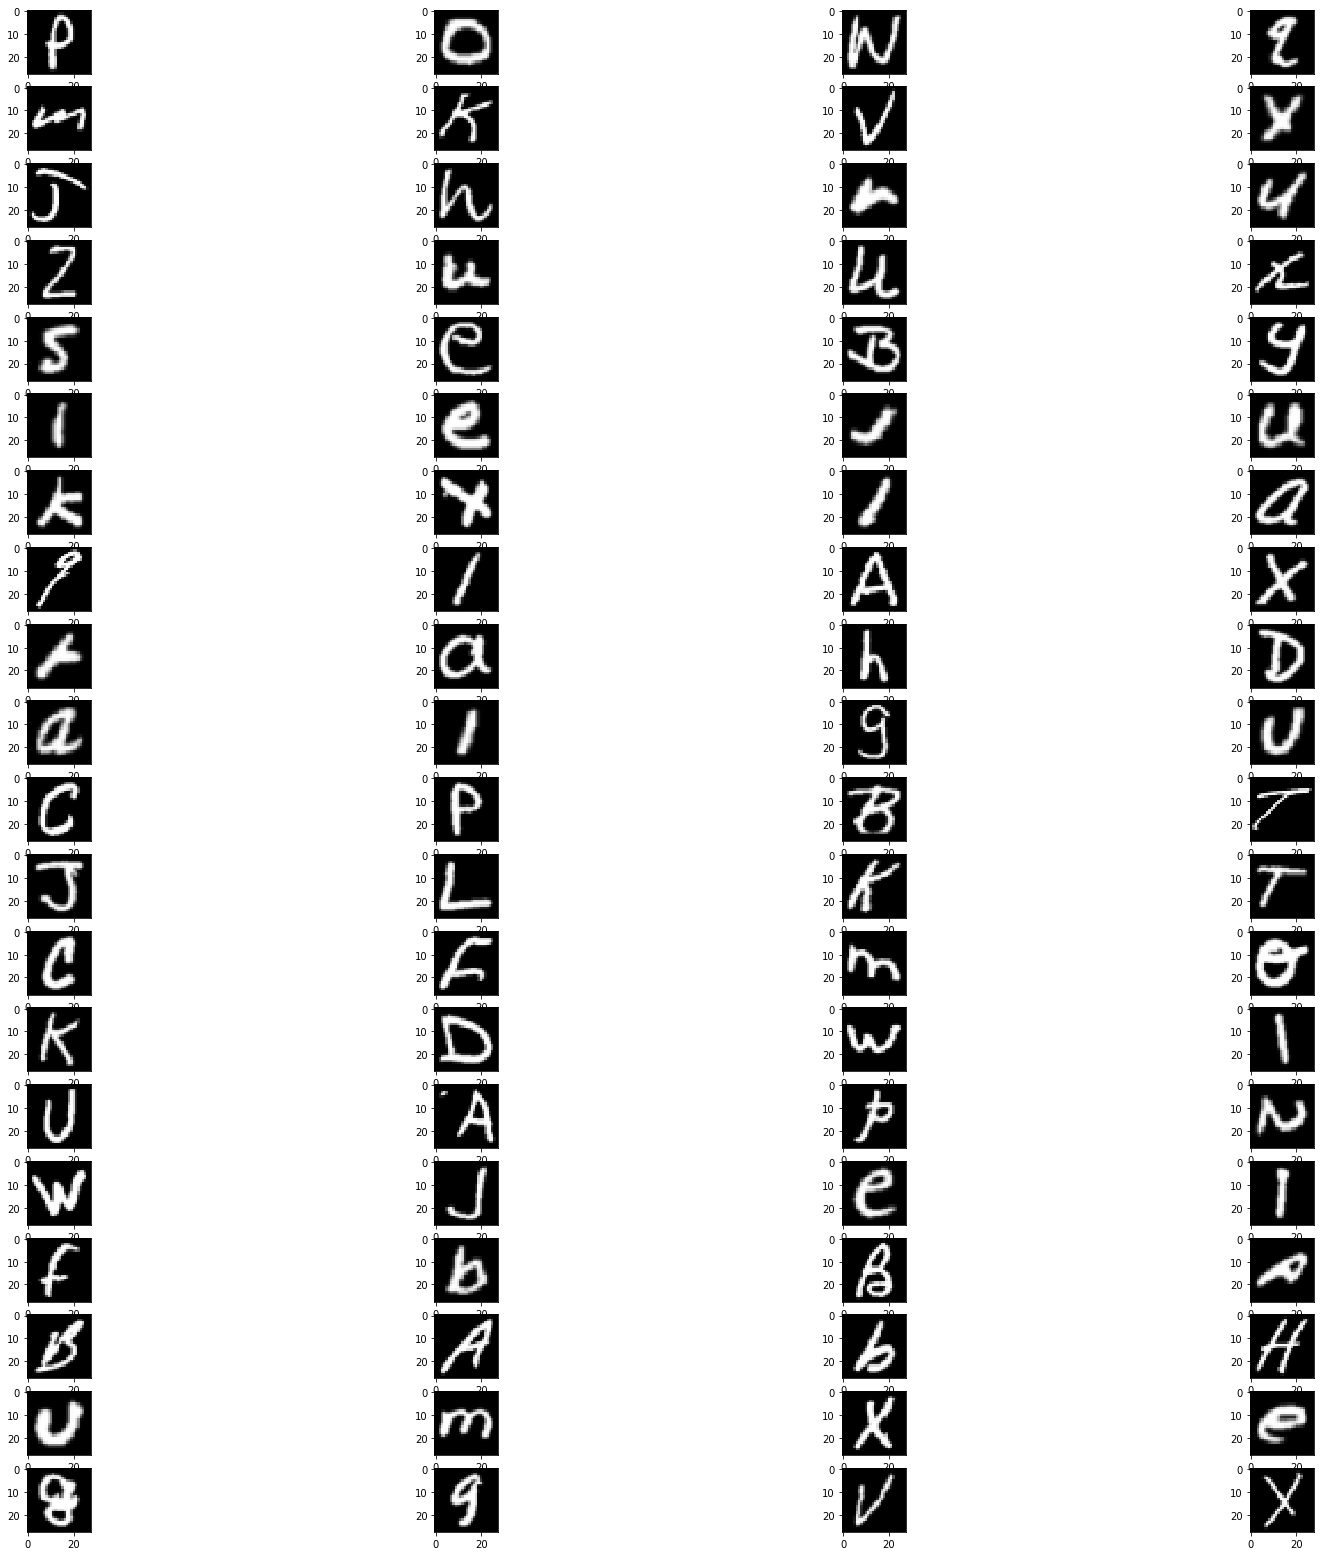

In [52]:
figure = plt.figure(figsize=(28, 28))
columns = 4
rows = 20
for i in range(1, columns * rows + 1):
    figure.add_subplot(rows, columns, i)
    plt.imshow(train_x[i], cmap='gray')